# EMODE - Face expression classifier

#### 1. Importing libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random

os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### 2. Constants


In [3]:
skip_training = True

In [4]:
img_size = 224
batch_size = 32
validation_split = 0.15
training_dir = "fer2013/train"
testing_dir = "fer2013/test"
classes = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

Image shape: (48, 48, 3)


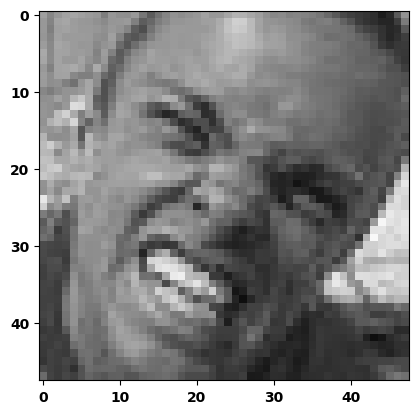

In [24]:
# Plot an example picture
img_array = cv2.imread("fer2013/train/0/Training_31442578.jpg")
print("Image shape:", img_array.shape)
plt.imshow(img_array)

#### 3. Data preprocessing (batch processing, resizing, normalization)

In [5]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    training_dir,
	target_size=(img_size, img_size),
	batch_size=batch_size,
	class_mode='sparse',
	subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
	testing_dir,
	target_size=(img_size, img_size),
	batch_size=batch_size,
	class_mode='sparse'
)

Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
for x_batch, y_batch in train_generator:
    print("Batch input shape:", x_batch.shape)
    print("Batch label shape:", y_batch.shape)
    print("Example label:", y_batch)
    break

Batch input shape: (32, 224, 224, 3)
Batch label shape: (32,)
Example label: [1. 4. 2. 2. 0. 5. 5. 3. 5. 3. 2. 3. 5. 3. 0. 5. 6. 0. 3. 3. 5. 3. 3. 3.
 3. 0. 6. 5. 4. 5. 5. 6.]


#### 4. Model

In [ ]:
# Load the pre-trained model
base_model = tf.keras.applications.MobileNetV2(
  weights='imagenet',
  include_top=False,
  input_shape=(img_size, img_size, 3)
)

In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [18]:
# Implement transfer learning
model = models.Sequential([
	base_model,
	layers.GlobalAveragePooling2D(),
	layers.Dense(128, activation='relu'),
	layers.Dense(64, activation='relu'),
	layers.Dense(7, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2,430,663
Trainable params: 2,396,551
No

In [20]:
model.compile(
	optimizer='adam',
	loss='sparse_categorical_crossentropy',
	metrics=['accuracy']
)

In [5]:
# Train the model
if not skip_training:
    model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator
    )
    model.save("EMODE.h5")
else:
    try:
        model = tf.keras.models.load_model("EMODE.h5")
        print("Model loaded successfully")
    except Exception as e:
        print("Error loading model")

Model loaded successfully


#### 5. Test the model

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_accuracy))

225/225 [==============================] - 102s 453ms/step - loss: 2.1645 - accuracy: 0.5157
Test loss: 2.1644623279571533
Test accuracy: 0.5157425403594971


Face not detected
Face not detected
1/1 [==============================] - 1s 738ms/step
Predicted probabilities for classes: [0.08044252 0.00437456 0.23080148 0.44179857 0.09196571 0.02503616
 0.12558101]
Predicted class: Happy


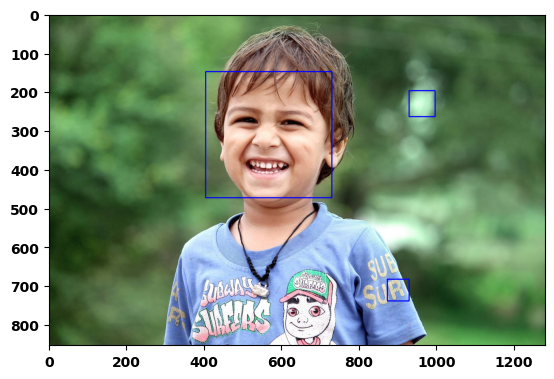

In [26]:
happy_boy_img = cv2.imread("happy_boy.jpg")
happy_boy_img_gray = cv2.cvtColor(happy_boy_img, cv2.COLOR_BGR2GRAY)

# Detect face
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = faceCascade.detectMultiScale(happy_boy_img_gray, 1.1, 4)
for (x, y, w, h) in faces:
	roi_gray = happy_boy_img_gray[y:y+h, x:x+w]
	roi_color = happy_boy_img[y:y+h, x:x+w]
	cv2.rectangle(happy_boy_img, (x, y), (x+w, y+h), (255, 0, 0), 2)
	faces = faceCascade.detectMultiScale(roi_gray)
	if len(faces) == 0:
		print("Face not detected")
	else:
		for (ex, ey, ew, eh) in faces:
			face_roi = roi_color[ey: ey+eh, ex: ex+ew]

plt.imshow(cv2.cvtColor(happy_boy_img, cv2.COLOR_BGR2RGB))
processed_roi = cv2.resize(face_roi, (img_size, img_size))
processed_roi = np.expand_dims(processed_roi, axis=0)
processed_roi = processed_roi/255.0
predictions = model.predict(processed_roi)
print("Predicted probabilities for classes:", predictions[0])
print("Predicted class:", classes[np.argmax(predictions[0])])

#### 6. Webcam demo

In [10]:
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture image")
        break

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    face_detected = False
    for x, y, w, h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        faces = faceCascade.detectMultiScale(roi_gray)
        if len(faces) == 0:
            print("Face not detected")
        else:
            for (ex, ey, ew, eh) in faces:
                face_roi = roi_color[ey: ey+eh, ex: ex+ew]
                face_detected = True

    if face_detected:
        final_image = cv2.resize(face_roi, (img_size, img_size))
        final_image = np.expand_dims(final_image, axis=0)
        final_image = final_image / 255.0

        predictions = model.predict(final_image)
        predicted_class = classes[np.argmax(predictions[0])]

        font = cv2.FONT_HERSHEY_PLAIN
        font_scale = 1.5

        x1, y1, w1, h1 = 0, 0, 175, 75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1+w1, y1+h1), (0, 0, 0), -1)
        # Add text
        cv2.putText(frame, predicted_class, (x1+int(w1/10), y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        cv2.putText(frame, predicted_class, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    cv2.imshow('Face Emotion Recognition', frame)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 39ms/step
Face not detected
1/1 [==============================] - 0s 31ms/step
Face not detected
Face not detected
1/1 [==============================] - 0s 33ms/step
Face not detected
1/1 [==============================] - 0s 37ms/step
Face not detected
1/1 [==============================] - 0s 59ms/step
Face not detected
Face not detected
1/1 [==============================] - 0s 36ms/step
Face not detected
Face not detected
Face not detected
Face not detected
1/1 [==============================] - 0s 37ms/step
Face not detected
1/1 [==============================] - 0s 46ms/step
Face not detected
Face not detected
Face not detected
1/1 [==============================] - 0s 40ms/step
Face not detected
Face not detected
1/1 [==============================] - 0s 39ms/step
Face not detected
1/1 [==============================] - 0s 38ms/step
Face not detected
1/1 [==============================] - 0s 33ms/step
Face not detected
Face not detecte